In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

np.random.seed(42)
X, y = make_moons(n_samples=1000, noise=0.2)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

def one_hot(y, k=2):
    Y = np.zeros((y.shape[0], k))
    Y[np.arange(y.shape[0]), y] = 1
    return Y
Y_train = one_hot(y_train, 2)
Y_test = one_hot(y_test, 2)


In [7]:
def sigmoid(z):
    return 1/(1+np.exp(-z))
def dsigmoid(a):
    return a*(1-a)
def tanh(z):
    return np.tanh(z)
def dtanh(a):
    return 1-a**2
def relu(z):
    return np.maximum(0, z)
def drelu(z):
    return (z>0).astype(float)

ACTS = {'sigmoid': (sigmoid, dsigmoid), 'tanh': (tanh, dtanh), 'relu': (relu, drelu)}

def softmax(z):
    z = z - np.max(z, axis=1, keepdims=True)
    exp = np.exp(z)
    return exp/np.sum(exp, axis=1, keepdims=True)
def cross_entropy(p, Y):
    eps=1e-9
    return -np.mean(np.sum(Y*np.log(p+eps), axis=1))


In [8]:
def init_params(input_dim=2, hidden=16, output_dim=2):
    W1 = np.random.randn(input_dim, hidden)*0.1
    b1 = np.zeros((1, hidden))
    W2 = np.random.randn(hidden, output_dim)*0.1
    b2 = np.zeros((1, output_dim))
    return {'W1':W1,'b1':b1,'W2':W2,'b2':b2}

def forward_backward(params, X, Y, act='relu'):
    f_act, d_act = ACTS[act]
    W1,b1,W2,b2 = params['W1'],params['b1'],params['W2'],params['b2']
    z1 = X@W1 + b1
    a1 = f_act(z1)
    z2 = a1@W2 + b2
    p = softmax(z2)
    loss = cross_entropy(p,Y)
    m = X.shape[0]
    dz2 = (p - Y)/m
    dW2 = a1.T@dz2
    db2 = np.sum(dz2, axis=0, keepdims=True)
    da1 = dz2@W2.T
    if act=='relu':
        dz1 = da1*drelu(z1)
    else:
        dz1 = da1*d_act(a1)
    dW1 = X.T@dz1
    db1 = np.sum(dz1, axis=0, keepdims=True)
    grads = {'dW1':dW1,'db1':db1,'dW2':dW2,'db2':db2}
    return loss, grads

def train_shallow(X, Y, hidden=16, lr=0.1, epochs=2000, act='relu'):
    params = init_params(hidden=hidden)
    losses=[]
    for e in range(epochs):
        loss, grads = forward_backward(params, X, Y, act)
        params['W1'] -= lr*grads['dW1']
        params['b1'] -= lr*grads['db1']
        params['W2'] -= lr*grads['dW2']
        params['b2'] -= lr*grads['db2']
        if (e+1)%100==0:
            losses.append(loss)
    return params, losses


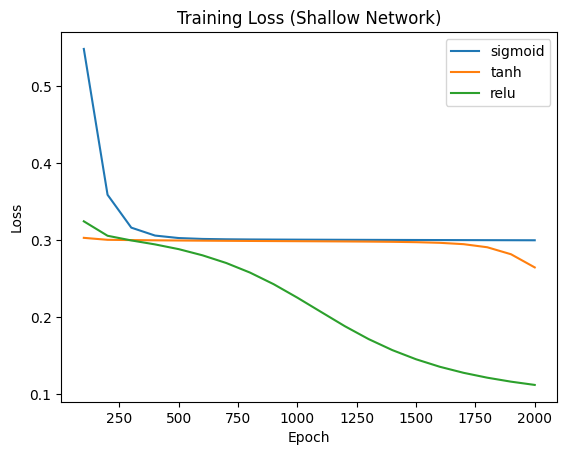

Best activation: relu Test acc: 0.98


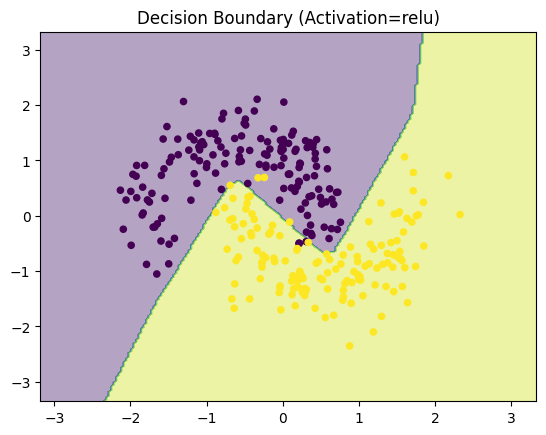

In [9]:
results={}
for act in ['sigmoid','tanh','relu']:
    params, losses = train_shallow(X_train, Y_train, hidden=16, lr=0.1, epochs=2000, act=act)
    results[act]=(params, losses)

fig, ax = plt.subplots()
for act,(params,losses) in results.items():
    ax.plot(np.arange(len(losses))*100+100, losses, label=act)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training Loss (Shallow Network)')
ax.legend()
plt.show()

def predict(params, X, act='relu'):
    f_act,_ = ACTS[act]
    z1 = X@params['W1'] + params['b1']
    a1 = f_act(z1)
    z2 = a1@params['W2'] + params['b2']
    p = softmax(z2)
    return np.argmax(p, axis=1)

best_act=None; best_acc=-1
for act,(params,_) in results.items():
    y_pred = predict(params, X_test, act)
    acc = accuracy_score(y_test, y_pred)
    if acc>best_acc:
        best_acc=acc; best_act=act; best_params=params
print('Best activation:', best_act, 'Test acc:', round(best_acc,4))

x_min,x_max = X[:,0].min()-1, X[:,0].max()+1
y_min,y_max = X[:,1].min()-1, X[:,1].max()+1
xx,yy = np.meshgrid(np.linspace(x_min,x_max,200), np.linspace(y_min,y_max,200))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = predict(best_params, grid, best_act).reshape(xx.shape)

fig, ax = plt.subplots()
ax.contourf(xx, yy, Z, alpha=0.4)
ax.scatter(X_test[:,0], X_test[:,1], c=y_test, s=20)
ax.set_title(f'Decision Boundary (Activation={best_act})')
plt.show()
